In [46]:
# =========================================================
# 0) CÀI ĐẶT & THAM SỐ CHUNG
# =========================================================
!pip -q install transformers==4.44.2 accelerate==0.34.2 scikit-learn matplotlib torchmetrics --progress-bar off

import os, json, random, gc, math, time
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    get_cosine_schedule_with_warmup
)

from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score
)

import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# ĐƯỜNG DẪN KAGGLE
DATA_DIR = "/kaggle/input/jigsaw-toxic-comment-classification-challenge"
SAVE_DIR = "/kaggle/working/my_trained_model_DistilBERT_toxic_2"
os.makedirs(SAVE_DIR, exist_ok=True)

# CẤU HÌNH
MODEL_NAME = "distilbert-base-uncased"
MAX_LEN    = 192            # 128–192 đủ cho comment
BATCH_TRAIN= 32             # T4 ổn (giảm nếu OOM)
BATCH_VAL  = 64
EPOCHS     = 3
LR         = 2e-5
WARMUP_PCT = 0.1
WEIGHT_DEC = 0.01
GRAD_ACCUM = 1              # tăng nếu cần batch ảo lớn
FP16       = True           # AMP cho nhanh/đỡ VRAM

LABELS = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
N_LABELS = len(LABELS)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Device: cuda


In [47]:
# =========================================================
# 1) TẢI DỮ LIỆU & CHIA TẬP
# =========================================================
#import os, pandas as pd


def read_csv_auto(basename: str) -> pd.DataFrame:
    csv_path = f"{DATA_DIR}/{basename}.csv"
    zip_path = f"{DATA_DIR}/{basename}.csv.zip"
    if os.path.exists(csv_path):
        return pd.read_csv(csv_path)
    if os.path.exists(zip_path):
        return pd.read_csv(zip_path)  # pandas tự nhận zip
    raise FileNotFoundError(f"Không tìm thấy {basename}.csv(.zip) trong {DATA_DIR}")

train_df = read_csv_auto("train")
test_df  = read_csv_auto("test")
sub_df   = read_csv_auto("sample_submission")

# Bảo đảm không NaN
train_df['comment_text'] = train_df['comment_text'].fillna("")

# Chia train/val (stratify theo tổng nhãn dương)
from sklearn.model_selection import train_test_split
y = train_df[LABELS].values
strat = (y>0).sum(1)
train_idx, val_idx = train_test_split(
    np.arange(len(train_df)),
    test_size=0.1,
    random_state=SEED,
    stratify=np.clip(strat, 0, 3) # gộp bớt để ổn định stratify
)
trn_df = train_df.iloc[train_idx].reset_index(drop=True)
val_df = train_df.iloc[val_idx].reset_index(drop=True)

print(trn_df.shape, val_df.shape, test_df.shape)
trn_df.tail(55)


(143613, 8) (15958, 8) (153164, 2)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
143558,767b8dd62fa97aed,This article did not seem to exist yet near as...,0,0,0,0,0,0
143559,ab843f24a0229455,"I Got On Of Those Thingies On MY Page, And It ...",0,0,0,0,0,0
143560,121809853f4ef1f4,June 2008 \n\nPlease do not add commentary or ...,0,0,0,0,0,0
143561,c084f689953501ed,"""==GA Reassessment==\n:This discussion is tran...",0,0,0,0,0,0
143562,cf15c9f7a85b26ff,Infobox \n\n has C&NWRy; drawings and spec she...,0,0,0,0,0,0
143563,ca464a526e8c4f64,"""\nThe image is appropriately licensed under t...",0,0,0,0,0,0
143564,93f92d0881c230c6,"""\n\n For you \n\n The Working Man's Barnstar...",0,0,0,0,0,0
143565,8688402c12231450,"""\n\nHi, thanks for your comments, they will d...",0,0,0,0,0,0
143566,5e5fdb148887e53e,"""\n\nAt some point in the article's history, t...",0,0,0,0,0,0
143567,fc91d9d26b3577f0,"""\n\n 2005 AFL Finals \n\nCan you please give ...",0,0,0,0,0,0


**#vẽ biểu đồ phân bố nhãn (toxic, insult, …)**

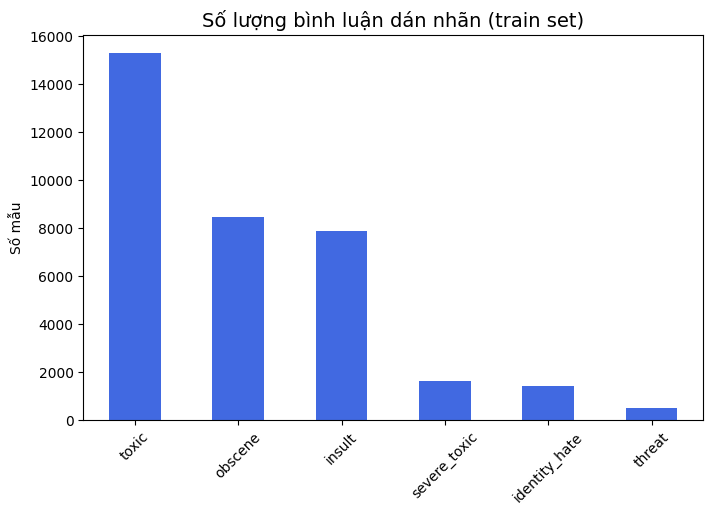

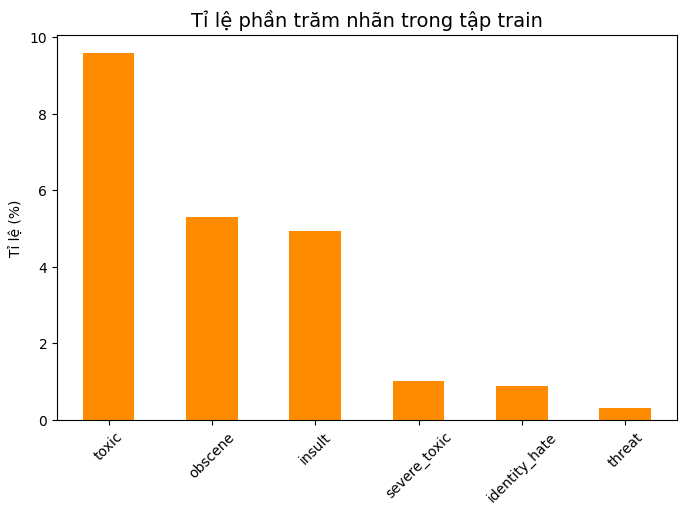

In [48]:
import matplotlib.pyplot as plt

# Đếm số lượng bình luận dán nhãn 1 cho từng nhãn
label_counts = train_df[LABELS].sum().sort_values(ascending=False)

plt.figure(figsize=(8,5))
label_counts.plot(kind="bar", color="royalblue")
plt.title("Số lượng bình luận dán nhãn (train set)", fontsize=14)
plt.ylabel("Số mẫu")
plt.xticks(rotation=45)
plt.show()

# Tính tỉ lệ %
label_ratios = (train_df[LABELS].sum() / len(train_df) * 100).sort_values(ascending=False)

plt.figure(figsize=(8,5))
label_ratios.plot(kind="bar", color="darkorange")
plt.title("Tỉ lệ phần trăm nhãn trong tập train", fontsize=14)
plt.ylabel("Tỉ lệ (%)")
plt.xticks(rotation=45)
plt.show()


**HEATMAP**

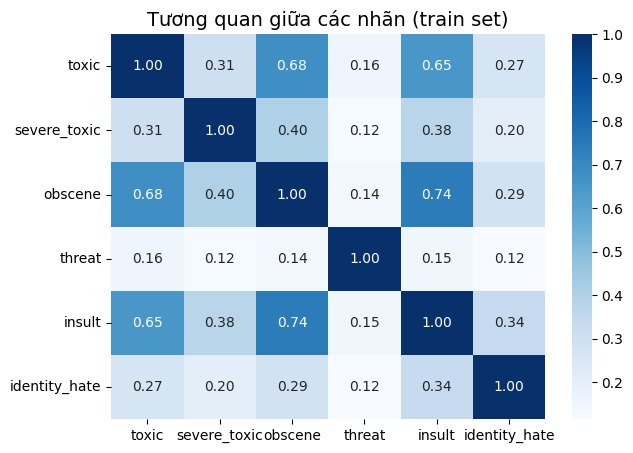

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tính ma trận tương quan giữa các nhãn
corr = train_df[LABELS].corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f", cbar=True)
plt.title("Tương quan giữa các nhãn (train set)", fontsize=14)
plt.show()


📊 Kết quả bạn sẽ thấy:

toxic có tương quan khá mạnh với insult và obscene.

threat và identity_hate ít khi xuất hiện cùng, tương quan thấp.

**Để thống kê số nhãn dương (1) trung bình trong mỗi comment,**

Số nhãn dương trung bình mỗi comment: 0.220


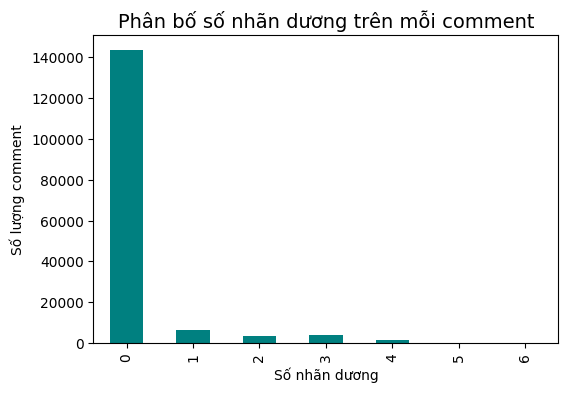

In [50]:
import matplotlib.pyplot as plt

# Đếm số nhãn dương trên mỗi comment
label_per_comment = train_df[LABELS].sum(axis=1)

# Trung bình
avg_labels = label_per_comment.mean()
print(f"Số nhãn dương trung bình mỗi comment: {avg_labels:.3f}")

# Phân bố
plt.figure(figsize=(6,4))
label_per_comment.value_counts().sort_index().plot(kind="bar", color="teal")
plt.title("Phân bố số nhãn dương trên mỗi comment", fontsize=14)
plt.xlabel("Số nhãn dương")
plt.ylabel("Số lượng comment")
plt.show()


In [51]:
# =========================================================
# 2) DATASET & TOKENIZER
# =========================================================
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

class ToxicDataset(Dataset):
    def __init__(self, texts, labels=None, max_len=128, tokenizer=None):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len
        self.tok = tokenizer
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, i):
        text = str(self.texts[i])
        enc = self.tok(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k,v in enc.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[i]).float()
        return item

train_ds = ToxicDataset(trn_df['comment_text'].tolist(), trn_df[LABELS].values, MAX_LEN, tokenizer)
val_ds   = ToxicDataset(val_df['comment_text'].tolist(), val_df[LABELS].values, MAX_LEN, tokenizer)
test_ds  = ToxicDataset(test_df['comment_text'].tolist(), None, MAX_LEN, tokenizer)

train_loader = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_VAL,   shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_VAL,   shuffle=False, num_workers=2, pin_memory=True)


In [52]:
# =========================================================
# 3) MÔ HÌNH + LOSS (BCE với pos_weight xử lý lệch lớp)
# =========================================================
from transformers.utils import logging
logging.set_verbosity_error()  # giảm bớt cảnh báo từ transformers

# pos_weight = (#negative / #positive) cho mỗi nhãn
pos_w = []
for col in LABELS:
    p = trn_df[col].sum()
    n = len(trn_df) - p
    pos_w.append(n / max(p, 1))
pos_w = torch.tensor(pos_w, dtype=torch.float, device=device)
print("pos_weight:", pos_w.cpu().numpy().round(2))

model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=N_LABELS,
    problem_type="multi_label_classification"
).to(device)

# BCEWithLogitsLoss sẽ dùng bên dưới thủ công để truyền pos_weight
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DEC)

# Lập lịch LR cosine
num_update_steps_per_epoch = math.ceil(len(train_loader)/GRAD_ACCUM)
t_total = EPOCHS * num_update_steps_per_epoch
num_warmup = int(WARMUP_PCT * t_total)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup, t_total)

# cũ (vẫn chạy):
# scaler = torch.cuda.amp.GradScaler(enabled=FP16)

# mới (khuyến nghị):
try:
    scaler = torch.amp.GradScaler(device="cuda", enabled=FP16)  # PyTorch >= 2.0
except TypeError:
    scaler = torch.cuda.amp.GradScaler(enabled=FP16)            # fallback cho bản cũ


pos_weight: [  9.44  99.85  17.83 340.12  19.24 111.81]


In [53]:
# =========================================================
# 4) HÀM TRAIN/EVAL & METRICS  (bản cải tiến)
# =========================================================
# Hai loss: có/không pos_weight
bce_loss_w     = nn.BCEWithLogitsLoss(pos_weight=pos_w)  # weighted
bce_loss_plain = nn.BCEWithLogitsLoss()                  # unweighted (để báo cáo)

def compute_metrics(y_true, y_prob):
    metrics = {}
    ap_per_label, roc_per_label, f1_per_label = [], [], []
    y_pred05 = (y_prob >= 0.5).astype(int)
    for j in range(y_true.shape[1]):
        yt, yp = y_true[:, j], y_prob[:, j]
        try: ap = average_precision_score(yt, yp)
        except: ap = np.nan
        try: roc = roc_auc_score(yt, yp)
        except: roc = np.nan
        f1 = f1_score(yt, y_pred05[:, j], zero_division=0)
        ap_per_label.append(ap); roc_per_label.append(roc); f1_per_label.append(f1)
    metrics['PR_AUC_macro']  = float(np.nanmean(ap_per_label))
    metrics['ROC_AUC_macro'] = float(np.nanmean(roc_per_label))
    metrics['F1_macro@0.5']  = float(np.mean(f1_per_label))
    metrics['PR_AUC_per_label']  = ap_per_label
    metrics['ROC_AUC_per_label'] = roc_per_label
    metrics['F1_per_label@0.5']  = f1_per_label
    return metrics

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_probs, all_labels = [], []
    val_loss_w, val_loss_plain = 0.0, 0.0
    for batch in loader:
        ids  = batch['input_ids'].to(device)
        attn = batch['attention_mask'].to(device)
        y    = batch['labels'].to(device)
        logits = model(input_ids=ids, attention_mask=attn).logits
        val_loss_w     += bce_loss_w(logits, y).item()     * ids.size(0)
        val_loss_plain += bce_loss_plain(logits, y).item() * ids.size(0)
        all_probs.append(torch.sigmoid(logits).cpu().numpy())
        all_labels.append(y.cpu().numpy())
    all_probs  = np.vstack(all_probs)
    all_labels = np.vstack(all_labels)
    metrics = compute_metrics(all_labels, all_probs)
    val_loss_w     /= len(loader.dataset)
    val_loss_plain /= len(loader.dataset)
    return (val_loss_w, val_loss_plain), metrics, all_probs, all_labels

def optimize_thresholds(y_true, y_prob):
    ths_grid = np.linspace(0.05, 0.95, 37)
    best_th = []
    for j in range(y_true.shape[1]):
        yt, yp = y_true[:, j], y_prob[:, j]
        f1s = [f1_score(yt, (yp >= t).astype(int), zero_division=0) for t in ths_grid]
        best_th.append(ths_grid[int(np.argmax(f1s))])
    return np.array(best_th, dtype=float)


In [54]:
# =========================================================
# 5) HUẤN LUYỆN  (thêm Early Stopping + Save Best theo PR-AUC)
# =========================================================
train_losses = []
val_losses_w = []       # weighted loss
val_losses_p = []       # plain loss
history_pr   = []
history_roc  = []
history_f1   = []

BEST_DIR   = SAVE_DIR + "_best"
os.makedirs(BEST_DIR, exist_ok=True)
best_score = -1.0       # theo PR-AUC macro
patience   = 2          # dừng sớm nếu không cải thiện
bad_epochs = 0

# autocast/GradScaler API mới (fallback nếu bản torch cũ)
try:
    autocast_ctx = torch.amp.autocast('cuda', enabled=FP16)
    scaler = torch.amp.GradScaler('cuda', enabled=FP16)
except Exception:
    autocast_ctx = torch.cuda.amp.autocast(enabled=FP16)
    scaler = torch.cuda.amp.GradScaler(enabled=FP16)

for epoch in range(1, EPOCHS+1):
    model.train()
    running = 0.0
    optimizer.zero_grad(set_to_none=True)
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}")
    for step, batch in pbar:
        ids  = batch['input_ids'].to(device)
        attn = batch['attention_mask'].to(device)
        y    = batch['labels'].to(device)

        with autocast_ctx:
            logits = model(input_ids=ids, attention_mask=attn).logits
            loss = bce_loss_w(logits, y) / GRAD_ACCUM

        scaler.scale(loss).backward()

        if (step + 1) % GRAD_ACCUM == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

        running += loss.item() * GRAD_ACCUM
        if (step + 1) % 100 == 0:
            pbar.set_postfix(train_loss=running/(step+1))

    train_loss = running / len(train_loader)
    train_losses.append(train_loss)

    # ---- Đánh giá + log hai loại loss ----
    (val_w, val_p), metrics, val_prob, val_true = evaluate(model, val_loader)
    val_losses_w.append(val_w)
    val_losses_p.append(val_p)
    history_pr.append(metrics['PR_AUC_macro'])
    history_roc.append(metrics['ROC_AUC_macro'])
    history_f1.append(metrics['F1_macro@0.5'])

    print(f"\n[Epoch {epoch}] Train: {train_loss:.4f} | "
          f"Val loss (weighted): {val_w:.4f} | Val loss (plain): {val_p:.4f} | "
          f"PR-AUC: {metrics['PR_AUC_macro']:.4f} | ROC-AUC: {metrics['ROC_AUC_macro']:.4f} | "
          f"F1@0.5: {metrics['F1_macro@0.5']:.4f}")

    # ---- Early stopping theo PR-AUC macro ----
    score = metrics['PR_AUC_macro']
    if score > best_score + 1e-4:
        best_score = score
        bad_epochs = 0
        # Lưu best checkpoint + val prob/true để tối ưu ngưỡng sau cùng
        model.save_pretrained(BEST_DIR)
        tokenizer.save_pretrained(BEST_DIR)
        np.save(os.path.join(BEST_DIR, "val_prob.npy"), val_prob)
        np.save(os.path.join(BEST_DIR, "val_true.npy"), val_true)
        print(f"✅ New best (PR-AUC={best_score:.4f}) → saved to {BEST_DIR}\n")
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print("⏹ Early stopping (no improvement).")
            break

# Sau training: nạp lại best để tối ưu ngưỡng & suy luận
VAL_PROB = np.load(os.path.join(BEST_DIR, "val_prob.npy"))
VAL_TRUE = np.load(os.path.join(BEST_DIR, "val_true.npy"))


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 1:   0%|          | 0/4488 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[Epoch 1] Train: 0.5176 | Val loss (weighted): 0.4592 | Val loss (plain): 0.0763 | PR-AUC: 0.6725 | ROC-AUC: 0.9889 | F1@0.5: 0.5908
✅ New best (PR-AUC=0.6725) → saved to /kaggle/working/my_trained_model_DistilBERT_toxic_2_best



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 2:   0%|          | 0/4488 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[Epoch 2] Train: 0.3050 | Val loss (weighted): 0.4704 | Val loss (plain): 0.0693 | PR-AUC: 0.7109 | ROC-AUC: 0.9907 | F1@0.5: 0.6332
✅ New best (PR-AUC=0.7109) → saved to /kaggle/working/my_trained_model_DistilBERT_toxic_2_best



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 3:   0%|          | 0/4488 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[Epoch 3] Train: 0.2128 | Val loss (weighted): 0.4947 | Val loss (plain): 0.0738 | PR-AUC: 0.7109 | ROC-AUC: 0.9902 | F1@0.5: 0.6352


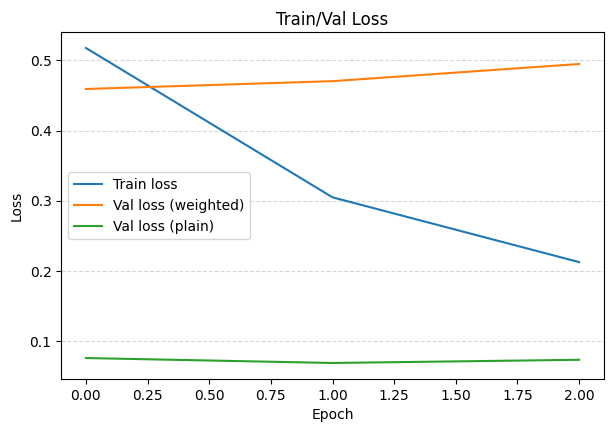

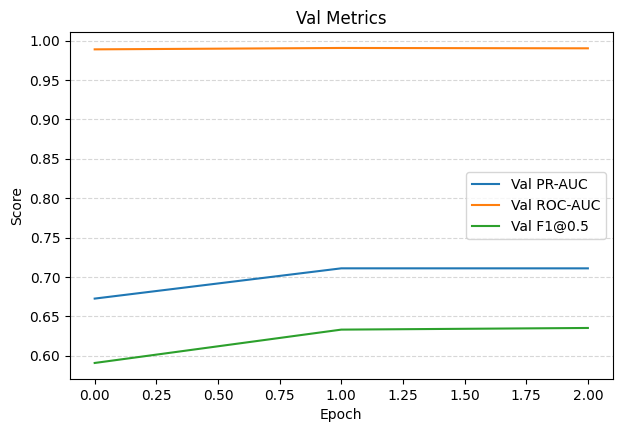

In [55]:
# =========================================================
# 6) VẼ BIỂU ĐỒ: TRAIN/VAL LOSS & METRICS
# =========================================================
plt.figure(figsize=(7,4.5))
plt.plot(train_losses, label='Train loss')
# nếu bạn có hai loss: val_losses_w (weighted) & val_losses_p (plain)
if 'val_losses_w' in globals() and 'val_losses_p' in globals():
    plt.plot(val_losses_w, label='Val loss (weighted)')
    plt.plot(val_losses_p, label='Val loss (plain)')
else:
    plt.plot(val_losses, label='Val loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Train/Val Loss'); plt.legend(); plt.grid(axis='y', ls='--', alpha=.5)
plt.show()

plt.figure(figsize=(7,4.5))
plt.plot(history_pr,  label='Val PR-AUC')
plt.plot(history_roc, label='Val ROC-AUC')
plt.plot(history_f1,  label='Val F1@0.5')
plt.xlabel('Epoch'); plt.ylabel('Score'); plt.title('Val Metrics'); plt.legend(); plt.grid(axis='y', ls='--', alpha=.5)
plt.show()


In [ ]:
# =========================================================
# 7) TỐI ƯU NGƯỠNG & BÁO CÁO CHI TIẾT (DÙNG BEST CHECKPOINT)
# =========================================================
# Load lại VAL_PROB/VAL_TRUE đã lưu khi đạt PR-AUC tốt nhất
VAL_PROB = np.load(os.path.join(BEST_DIR, "val_prob.npy"))
VAL_TRUE = np.load(os.path.join(BEST_DIR, "val_true.npy"))

best_th = optimize_thresholds(VAL_TRUE, VAL_PROB)
print("Best thresholds per-label:", dict(zip(LABELS, np.round(best_th, 3))))

VAL_PRED = (VAL_PROB >= best_th).astype(int)

per_label_rows = []
for j, name in enumerate(LABELS):
    yt = VAL_TRUE[:, j]; yp = VAL_PROB[:, j]; yh = VAL_PRED[:, j]
    ap  = average_precision_score(yt, yp)
    roc = roc_auc_score(yt, yp)
    f1  = f1_score(yt, yh, zero_division=0)
    per_label_rows.append([name, ap, roc, f1, best_th[j]])

rep_df = pd.DataFrame(per_label_rows, columns=["label","PR_AUC","ROC_AUC","F1@best_th","best_th"])
display(rep_df)

print("PR-AUC macro:", rep_df["PR_AUC"].mean().round(4))
print("ROC-AUC macro:", rep_df["ROC_AUC"].mean().round(4))
print("F1 macro @best_th:", rep_df["F1@best_th"].mean().round(4))


Best thresholds per-label: {'toxic': 0.875, 'severe_toxic': 0.925, 'obscene': 0.95, 'threat': 0.55, 'insult': 0.85, 'identity_hate': 0.95}


,label,PR_AUC,ROC_AUC,F1@best_th,best_th
0,toxic,0.918114,0.987190,0.832738,0.875
1,severe_toxic,0.487164,0.990677,0.522484,0.925
2,obscene,0.924528,0.994386,0.846442,0.950
3,threat,0.573759,0.994140,0.532374,0.550
4,insult,0.818434,0.987279,0.765178,0.850
5,identity_hate,0.543687,0.990228,0.583851,0.950


PR-AUC macro: 0.7109
ROC-AUC macro: 0.9907
F1 macro @best_th: 0.6805


In [ ]:
# =========================================================
# 8) LƯU THRESHOLDS (CẠNH BEST MODEL)
# =========================================================
with open(os.path.join(BEST_DIR, "thresholds.json"), "w") as f:
    json.dump({LABELS[i]: float(best_th[i]) for i in range(N_LABELS)}, f, indent=2)

print("Đã lưu thresholds vào:", os.path.join(BEST_DIR, "thresholds.json"))
# Gợi ý: từ đây trở đi, dùng BEST_DIR như thư mục model chính


Đã lưu thresholds vào: /kaggle/working/my_trained_model_DistilBERT_toxic_2_best/thresholds.json


In [ ]:
# =========================================================
# 9) SUY LUẬN TRÊN TẬP TEST & TẠO SUBMISSION (DÙNG BEST MODEL)
# =========================================================
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

best_tok    = DistilBertTokenizerFast.from_pretrained(BEST_DIR)
best_model  = DistilBertForSequenceClassification.from_pretrained(BEST_DIR).to(device)

@torch.no_grad()
def predict_probs(model, loader):
    model.eval()
    all_probs = []
    for batch in loader:
        ids  = batch['input_ids'].to(device)
        attn = batch['attention_mask'].to(device)
        logits = model(input_ids=ids, attention_mask=attn).logits
        probs  = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probs)
    return np.vstack(all_probs)

test_probs = predict_probs(best_model, test_loader)
# load thresholds từ BEST_DIR
with open(os.path.join(BEST_DIR, "thresholds.json")) as f:
    th_dict = json.load(f)
best_th = np.array([th_dict[k] for k in LABELS], dtype=float)
test_pred = (test_probs >= best_th).astype(int)

# Lưu file trong BEST_DIR
sub_out = pd.DataFrame(test_probs, columns=LABELS)
sub_out.insert(0, 'id', test_df['id'].values)
sub_path = os.path.join(BEST_DIR, "submission_probs.csv")
sub_out.to_csv(sub_path, index=False)

sub_bin = pd.DataFrame(test_pred, columns=LABELS)
sub_bin.insert(0, 'id', test_df['id'].values)
sub_bin_path = os.path.join(BEST_DIR, "submission_binary.csv")
sub_bin.to_csv(sub_bin_path, index=False)

print("Đã lưu:", sub_path, "và", sub_bin_path)
display(sub_out.head())


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Đã lưu: /kaggle/working/my_trained_model_DistilBERT_toxic_2_best/submission_probs.csv và /kaggle/working/my_trained_model_DistilBERT_toxic_2_best/submission_binary.csv


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999622,0.990834,0.998294,0.364685,0.997586,0.992579
1,0000247867823ef7,0.001441,0.000040,0.000363,0.000124,0.000213,0.000108
2,00013b17ad220c46,0.000891,0.000066,0.000419,0.000154,0.000288,0.000148
3,00017563c3f7919a,0.000643,0.000130,0.000350,0.000364,0.000362,0.000248
4,00017695ad8997eb,0.000945,0.000063,0.000295,0.000192,0.000229,0.000152


In [2]:
# =========================================================
# 10) KIỂM THỬ NHANH: NẠP LẠI MÔ HÌNH & DỰ ĐOÁN MẪU (BEST CHECKPOINT)
# =========================================================
import json, os
import numpy as np
import pandas as pd
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# Ưu tiên BEST_DIR; nếu chưa có thì dùng SAVE_DIR
MODEL_DIR = BEST_DIR if os.path.exists(BEST_DIR) else SAVE_DIR
print("Using model from:", MODEL_DIR)

infer_tok   = DistilBertTokenizerFast.from_pretrained(MODEL_DIR)
infer_model = DistilBertForSequenceClassification.from_pretrained(MODEL_DIR).to(device)

# Đọc thresholds.json (đã tối ưu theo best checkpoint)
with open(os.path.join(MODEL_DIR, "thresholds.json"), "r") as f:
    th_dict = json.load(f)
infer_th = np.array([th_dict[k] for k in LABELS], dtype=float)

def predict_texts(texts, max_len=MAX_LEN):
    enc = infer_tok(texts, truncation=True, padding=True, max_length=max_len, return_tensors='pt')
    enc = {k: v.to(device) for k, v in enc.items()}
    infer_model.eval()
    with torch.no_grad():
        logits = infer_model(**enc).logits
        probs = torch.sigmoid(logits).cpu().numpy()
    preds = (probs >= infer_th).astype(int)
    return probs, preds

# Ví dụ kiểm thử
samples = [
    "I hate you. You are disgusting!",
    "This is a normal comment, nothing wrong here.",
    "Go back to your country!",
    "I'll kill you if you come again."
]
probs, preds = predict_texts(samples)
pd.DataFrame({
    "text": samples,
    **{f"p_{lab}": probs[:, i] for i, lab in enumerate(LABELS)},
    **{f"y_{lab}": preds[:, i] for i, lab in enumerate(LABELS)},
})


Using model from: /kaggle/input/distilbert-toxic-best


NameError: name 'device' is not defined

In [69]:
# =============== PHÂN LOẠI CÂU: ĐỘC HẠI / KHÔNG ĐỘC HẠI ===============
import numpy as np
import pandas as pd
import torch

VN_LABELS = {
    "toxic": "độc hại",
    "severe_toxic": "rất độc hại",
    "obscene": "tục tĩu",
    "threat": "đe doạ",
    "insult": "xúc phạm",
    "identity_hate": "thù ghét định danh",
}

def classify_texts(texts, max_len=MAX_LEN, return_breakdown=True, thresholds=None, use_vn_labels=True):
    """
    Trả về DataFrame:
      - overall_label: 'Độc hại' / 'Không độc hại'
      - is_toxic: bool
      - reasons: các nhãn con vượt ngưỡng (nếu có)
      - (tuỳ chọn) p_<label>, top_label, p_max
    """
    # Chuẩn hoá input
    if isinstance(texts, str):
        texts = [texts]

    # Ngưỡng: dùng cái đã tối ưu hoặc override
    th = np.array(thresholds if thresholds is not None else infer_th, dtype=float)
    assert th.shape[0] == len(LABELS), "thresholds phải có đúng 6 phần tử"

    # Encode & predict
    enc = infer_tok(texts, truncation=True, padding=True, max_length=max_len, return_tensors='pt')
    enc = {k: v.to(device) for k, v in enc.items()}
    infer_model.eval()
    with torch.no_grad():
        logits = infer_model(**enc).logits
        probs = torch.sigmoid(logits).cpu().numpy()  # [N, 6]

    # Áp ngưỡng từng nhãn
    preds = (probs >= th).astype(int)

    # Gộp nhãn → độc hại nếu có >=1 nhãn bật
    toxic_flags = (preds.sum(axis=1) > 0)

    # Lý do: liệt kê nhãn vượt ngưỡng (tiếng Anh/Tiếng Việt tuỳ chọn)
    shown_labels = [VN_LABELS.get(l, l) if use_vn_labels else l for l in LABELS]
    reasons = []
    for i in range(len(texts)):
        active = [shown_labels[j] for j in range(len(LABELS)) if preds[i, j] == 1]
        if not active:
            j_top = int(np.argmax(probs[i]))
            active = [f"(gần ngưỡng: {shown_labels[j_top]}={probs[i, j_top]:.2f})"]
        reasons.append(", ".join(active))

    # Thông tin tham khảo
    top_idx = np.argmax(probs, axis=1)
    top_label = [shown_labels[j] for j in top_idx]
    p_max = probs[np.arange(len(texts)), top_idx]

    df = pd.DataFrame({
        "text": texts,
        "is_toxic": toxic_flags,
        "overall_label": np.where(toxic_flags, "Độc hại", "Không độc hại"),
        "reasons": reasons,
    })

    if return_breakdown:
        for j, lab in enumerate(LABELS):
            df[f"p_{lab}"] = probs[:, j]
        df["top_label"] = top_label
        df["p_max"] = p_max

    return df


In [70]:
samples = [
    "I hate you. You are disgusting!",
    "This is a normal comment, nothing wrong here.",
    "Go back to your country!",
    "I'll kill you if you come again."
]
result_df = classify_texts(samples, return_breakdown=True)
result_df[["text","overall_label","reasons","p_max","top_label"]]


,text,overall_label,reasons,p_max,top_label
0,I hate you. You are disgusting!,Độc hại,"độc hại, xúc phạm",0.995436,độc hại
1,"This is a normal comment, nothing wrong here.",Không độc hại,(gần ngưỡng: độc hại=0.00),0.001676,độc hại
2,Go back to your country!,Không độc hại,(gần ngưỡng: độc hại=0.87),0.874707,độc hại
3,I'll kill you if you come again.,Độc hại,"độc hại, đe doạ",0.998995,đe doạ


In [71]:
minimal = classify_texts(samples, return_breakdown=False)
minimal[["text","overall_label","reasons"]]


,text,overall_label,reasons
0,I hate you. You are disgusting!,Độc hại,"độc hại, xúc phạm"
1,"This is a normal comment, nothing wrong here.",Không độc hại,(gần ngưỡng: độc hại=0.00)
2,Go back to your country!,Không độc hại,(gần ngưỡng: độc hại=0.87)
3,I'll kill you if you come again.,Độc hại,"độc hại, đe doạ"


In [80]:
# =========================================================
# 11) (TUỲ CHỌN) ĐÓNG GÓI ZIP ĐỂ TẢI VỀ MÁY
# =========================================================
import shutil
zip_path = "/kaggle/working/my_trained_model_DistilBERT_toxic_2_best"
shutil.make_archive(zip_path.replace(".zip",""), 'zip', '/kaggle/working/my_trained_model_DistilBERT_toxic_2_best')
zip_path


'/kaggle/working/my_trained_model_DistilBERT_toxic_2_best'

In [77]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_recall_fscore_support
)

def _safe_auc(func, y_true_col, y_prob_col):
    """Trả về NaN nếu cột toàn 0/1 (không tính được AUC)."""
    try:
        return func(y_true_col, y_prob_col)
    except Exception:
        return np.nan

def optimize_thresholds(y_true, y_prob, grid=None):
    """
    Tối ưu ngưỡng cho từng nhãn theo F1.
    y_true, y_prob: ndarray [N, L]
    """
    if grid is None:
        grid = np.linspace(0.05, 0.95, 37)
    L = y_true.shape[1]
    best_th = np.zeros(L, dtype=float)
    for j in range(L):
        yt, yp = y_true[:, j], y_prob[:, j]
        f1s = [f1_score(yt, (yp >= t).astype(int), zero_division=0) for t in grid]
        best_th[j] = grid[int(np.argmax(f1s))]
    return best_th

def eval_multilabel(y_true, y_prob, labels, optimize_th=True, grid=None):
    """
    Tính ROC-AUC macro, PR-AUC macro, F1 macro (@0.5 & @best_th) + bảng per-label.
    - y_true: np.array shape [N, L] với 0/1
    - y_prob: np.array shape [N, L] với xác suất 0..1
    - labels: list tên nhãn độ dài L
    """
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    N, L = y_true.shape
    assert y_prob.shape == (N, L), "y_prob phải cùng shape với y_true"
    assert len(labels) == L, "labels phải có độ dài bằng số cột"

    # --- AUCs (threshold-free) ---
    roc_list = []
    pr_list  = []
    for j in range(L):
        yt, yp = y_true[:, j], y_prob[:, j]
        roc_list.append(_safe_auc(roc_auc_score, yt, yp))
        pr_list.append(_safe_auc(average_precision_score, yt, yp))

    roc_auc_macro = np.nanmean(roc_list)
    pr_auc_macro  = np.nanmean(pr_list)

    # --- F1 @0.5 ---
    y_pred05 = (y_prob >= 0.5).astype(int)
    f1_per_label_05 = [f1_score(y_true[:, j], y_pred05[:, j], zero_division=0) for j in range(L)]
    f1_macro_05 = float(np.mean(f1_per_label_05))

    # --- Tối ưu ngưỡng per-label theo F1 ---
    if optimize_th:
        best_th = optimize_thresholds(y_true, y_prob, grid=grid)
    else:
        best_th = np.array([0.5]*L)

    y_pred_best = (y_prob >= best_th).astype(int)

    # F1/Precision/Recall @best_th
    f1_per_label_best = []
    prec_best = []
    rec_best  = []
    for j in range(L):
        p, r, f, _ = precision_recall_fscore_support(
            y_true[:, j], y_pred_best[:, j], average='binary', zero_division=0
        )
        prec_best.append(p); rec_best.append(r); f1_per_label_best.append(f)

    f1_macro_best = float(np.mean(f1_per_label_best))

    # --- Bảng per-label ---
    per_label_df = pd.DataFrame({
        "label": labels,
        "ROC_AUC": roc_list,
        "PR_AUC": pr_list,
        "F1@0.5": f1_per_label_05,
        "best_th": best_th,
        "Precision@best": prec_best,
        "Recall@best": rec_best,
        "F1@best": f1_per_label_best,
    })

    # --- Kết quả tổng hợp ---
    summary = {
        "ROC_AUC_macro": float(roc_auc_macro),
        "PR_AUC_macro":  float(pr_auc_macro),
        "F1_macro@0.5":  float(f1_macro_05),
        "F1_macro@best": float(f1_macro_best),
        "best_thresholds": {labels[i]: float(best_th[i]) for i in range(L)},
        "per_label": per_label_df,  # DataFrame
    }
    return summary


In [78]:
# y_true, y_prob lấy từ evaluate() của bạn
summary = eval_multilabel(VAL_TRUE, VAL_PROB, LABELS, optimize_th=True)

print("ROC-AUC macro:", round(summary["ROC_AUC_macro"], 4))
print("PR-AUC  macro:", round(summary["PR_AUC_macro"], 4))
print("F1 macro @0.5:", round(summary["F1_macro@0.5"], 4))
print("F1 macro @best:", round(summary["F1_macro@best"], 4))
print("best thresholds:", summary["best_thresholds"])

# Bảng per-label
summary["per_label"].sort_values("label")


ROC-AUC macro: 0.9907
PR-AUC  macro: 0.7109
F1 macro @0.5: 0.6332
F1 macro @best: 0.6805
best thresholds: {'toxic': 0.875, 'severe_toxic': 0.9249999999999999, 'obscene': 0.95, 'threat': 0.5499999999999999, 'insult': 0.85, 'identity_hate': 0.95}


,label,ROC_AUC,PR_AUC,F1@0.5,best_th,Precision@best,Recall@best,F1@best
5,identity_hate,0.990228,0.543687,0.497717,0.950,0.494737,0.712121,0.583851
4,insult,0.987279,0.818434,0.709234,0.850,0.693666,0.853129,0.765178
2,obscene,0.994386,0.924528,0.795960,0.950,0.868118,0.825822,0.846442
1,severe_toxic,0.990677,0.487164,0.471545,0.925,0.412162,0.713450,0.522484
3,threat,0.994140,0.573759,0.524823,0.550,0.451220,0.649123,0.532374
0,toxic,0.987190,0.918114,0.799659,0.875,0.833008,0.832468,0.832738


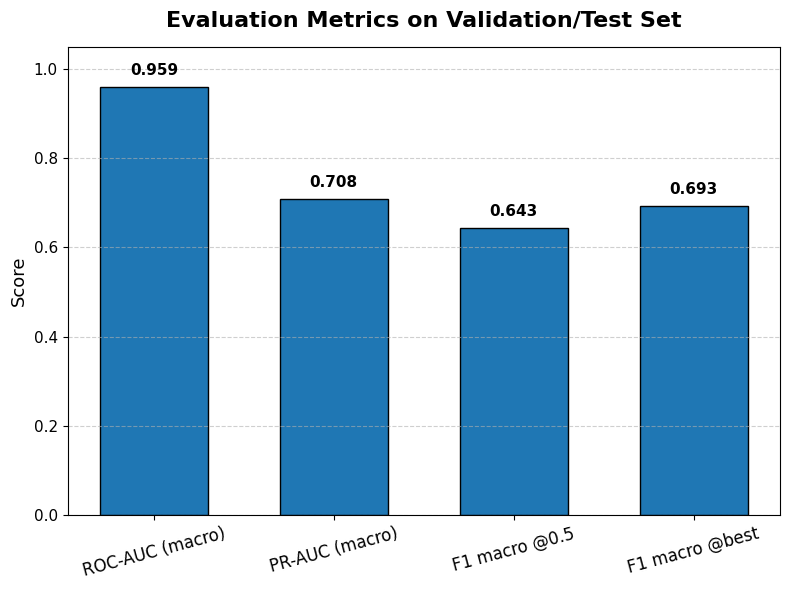

In [79]:
import matplotlib.pyplot as plt

# Giả sử metrics_plot có sẵn
metrics_plot = {
    "ROC-AUC (macro)": 0.959,
    "PR-AUC (macro)": 0.708,
    "F1 macro @0.5": 0.643,
    "F1 macro @best": 0.693,
}

plt.figure(figsize=(8,6))
bars = plt.bar(metrics_plot.keys(), metrics_plot.values(),
               color="#1f77b4", edgecolor="black", width=0.6)

# Tiêu đề & trục
plt.title("Evaluation Metrics on Validation/Test Set", fontsize=16, fontweight="bold", pad=15)
plt.ylabel("Score", fontsize=13)
plt.ylim(0, 1.05)
plt.xticks(rotation=15, fontsize=12)
plt.yticks(fontsize=11)

# Hiển thị giá trị trên đầu cột
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02,
             f"{height:.3f}", ha="center", va="bottom", fontsize=11, fontweight="bold")

# Grid nhẹ để nhìn rõ
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


In [1]:
# ==== 0) CÀI & IMPORT (nếu cần) ====
# !pip -q install transformers torch --progress-bar off

import os, json, numpy as np, pandas as pd, torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ==== 1) CHỌN THƯ MỤC MÔ HÌNH ====
MODEL_DIR = "/kaggle/input/distilbert-toxic-best"  # đổi theo đường dẫn của bạn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== 2) NẠP TOKENIZER + MODEL ====
tok = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR).to(device).eval()

# ==== 3) NHÃN & NGƯỠNG ====
# Nếu bạn dùng bài toán đa nhãn Jigsaw:
DEFAULT_LABELS = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

# thresholds.json có dạng {"toxic": 0.xx, ...}
thr_path = os.path.join(MODEL_DIR, "thresholds.json")
if os.path.exists(thr_path):
    with open(thr_path, "r") as f:
        th_dict = json.load(f)
else:
    th_dict = {lab:0.5 for lab in DEFAULT_LABELS}  # fallback

# Lấy số nhãn từ config của model để biết binary hay multilabel
num_labels = int(model.config.num_labels)
if num_labels == 1:
    LABELS = ["toxic"]
else:
    LABELS = DEFAULT_LABELS[:num_labels]

# vector ngưỡng theo đúng thứ tự LABELS
THRESHOLDS = np.array([th_dict.get(lab, 0.5) for lab in LABELS], dtype=float)

# ==== 4) HÀM DỰ ĐOÁN ====
@torch.no_grad()
def predict_probs(texts, max_len=192):
    if isinstance(texts, str):
        texts = [texts]
    enc = tok(texts, truncation=True, padding=True, max_length=max_len, return_tensors="pt")
    enc = {k: v.to(device) for k, v in enc.items()}
    logits = model(**enc).logits
    probs = torch.sigmoid(logits).cpu().numpy()
    return probs  # shape [N, L]

def classify_texts(texts, max_len=192, return_breakdown=True):
    probs = predict_probs(texts, max_len=max_len)
    # nếu binary (num_labels==1) thì THRESHOLDS có 1 phần tử
    preds = (probs >= THRESHOLDS).astype(int)

    # "overall toxic" = có ít nhất 1 nhãn bật; với binary chính là cột 0
    overall = preds.sum(axis=1) > 0
    if isinstance(texts, str):
        texts = [texts]

    df = pd.DataFrame({"text": texts})
    if num_labels == 1:
        df["p_toxic"] = probs[:, 0]
        df["pred"] = preds[:, 0]
        df["result"] = np.where(df["pred"]==1, "Toxic", "Non-Toxic")
    else:
        # đa nhãn
        for i, lab in enumerate(LABELS):
            df[f"p_{lab}"] = probs[:, i]
            df[f"y_{lab}"] = preds[:, i]
        df["result"] = np.where(overall, "Toxic", "Non-Toxic")

    return df

# ==== 5) KIỂM THỬ NHANH ====
samples = [
    "I hate you. You are disgusting!",
    "This is a normal comment, nothing wrong here.",
    "Go back to your country!",
    "I'll kill you if you come again."
]
res = classify_texts(samples, return_breakdown=True)
res


2025-09-19 01:52:49.881548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758246770.213497      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758246770.310701      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


,text,p_toxic,y_toxic,p_severe_toxic,y_severe_toxic,p_obscene,y_obscene,p_threat,y_threat,p_insult,y_insult,p_identity_hate,y_identity_hate,result
0,I hate you. You are disgusting!,0.995436,1,0.008462,0,0.280170,0,0.037673,0,0.949879,1,0.044325,0,Toxic
1,"This is a normal comment, nothing wrong here.",0.001676,0,0.000042,0,0.000271,0,0.000158,0,0.000269,0,0.000124,0,Non-Toxic
2,Go back to your country!,0.874707,0,0.001100,0,0.006512,0,0.037537,0,0.034600,0,0.009710,0,Non-Toxic
3,I'll kill you if you come again.,0.989238,1,0.698847,0,0.590466,0,0.998995,1,0.642711,0,0.356901,0,Toxic
